<h1 style="text-align:center;font-family:Didot;">Value at risk</h1>

In [1]:
import os
from collections import namedtuple
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from arch import arch_model
from scipy.stats import chi2, kstest, levy_stable, norm, t
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA

In [2]:
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize': (14, 8)})
sns.set(font_scale=1.5)

In [ ]:
def get_logreturns(name):
    df = pd.read_csv(os.path.join('data', 'fit', f'{name}_fit.csv'))

    date = pd.to_datetime(df.date).to_numpy(dtype = 'datetime64[D]')
    data = df.price.to_numpy() / 1000

    diff = (date[1:] - date[:-1]).astype('float64') / 365.25
    return np.diff(np.log(data)) / diff

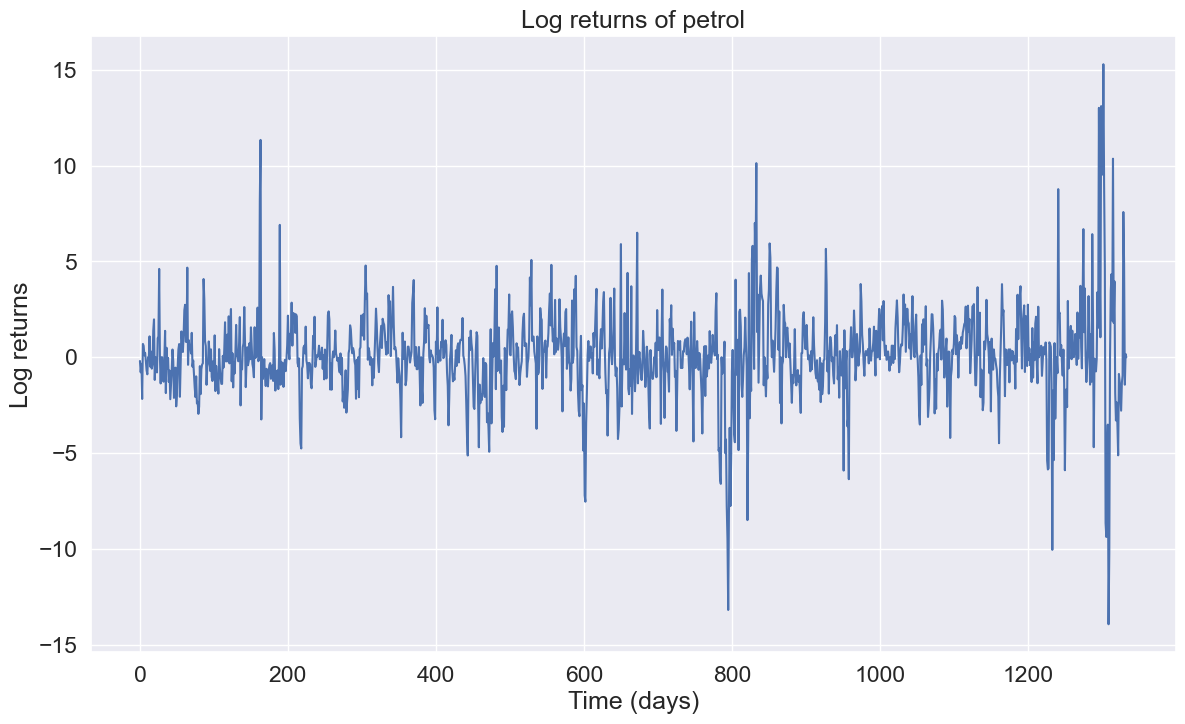

In [5]:
L = get_logreturns("petrol")

plt.plot(L)
plt.title("Log returns of petrol")
plt.xlabel("Time (days)")
plt.ylabel("Log returns")
plt.show()

<h2 style="text-align:center;font-family:Didot;">Part I</h2>

<h3 style="text-align:center;font-family:Didot;">Estimating VaR using parametric method &mdash; stable distribution</h3>

___

In [6]:
def stable_rv(variable):
    return levy_stable(*levy_stable._fitstart(variable))

In [7]:
def var_plot(variable, rv, VaR95, VaR99, show_pdf=False, variable_name="petrol", label="stable dist. pdf"):
    sns.histplot(variable, stat="density", color="royalblue", alpha=0.5, 
                 label=f"{variable_name} log returns \n(density histogram)")
    plt.axvline(VaR95, color="tomato", linestyle="--", lw=2, label="$x = VaR_{0.95}$", zorder=3)
    plt.axvline(VaR99, color="red", linestyle=":", lw=2.5, label="$x = VaR_{0.99}$", zorder=4)

    if show_pdf:
        xs = np.linspace(min(variable), max(variable), 1000)
        ys = rv.pdf(xs)
        sns.lineplot(x=xs, y=ys, color="navy", lw=2.5, label=label)
    plt.legend()
    plt.show()

In [8]:
rv = stable_rv(L)
VaR95_stable = rv.ppf(0.95)
VaR99_stable = rv.ppf(0.99)
VaR95_stable, VaR99_stable

(3.320695746489951, 9.569066748095933)

In [9]:
kstest(L, rv.cdf)

KstestResult(statistic=0.028138036304343528, pvalue=0.23700169871883126, statistic_location=2.041408461584429, statistic_sign=-1)

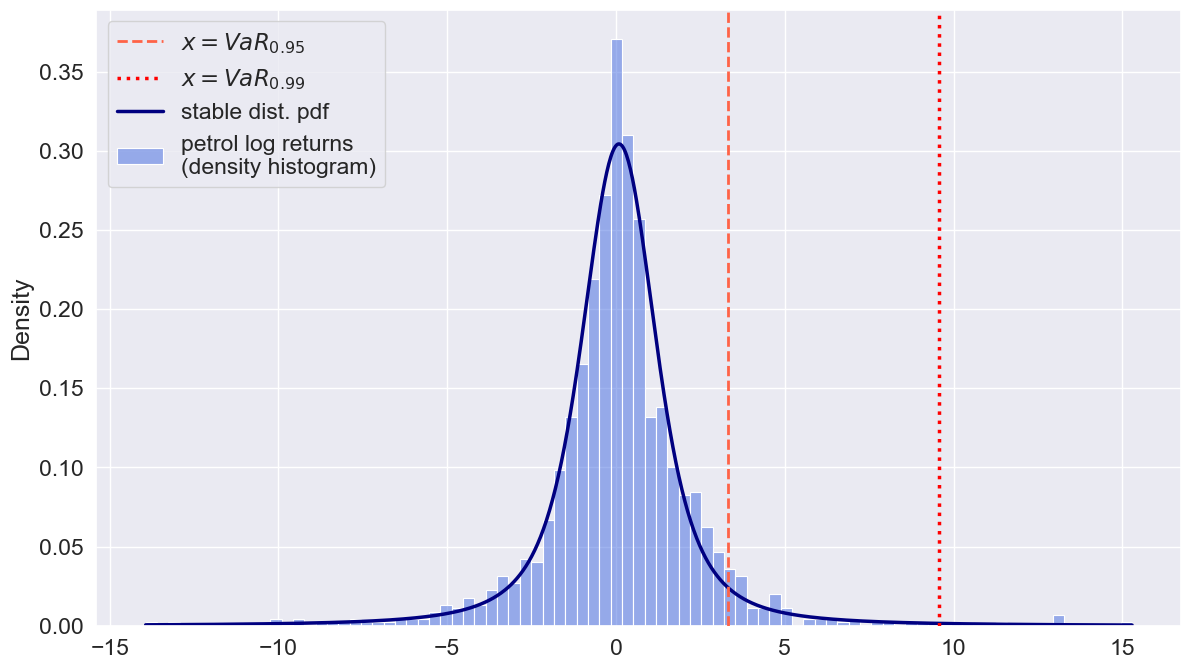

In [10]:
var_plot(L, rv, VaR95_stable, VaR99_stable, show_pdf=True)

<h3 style="text-align:center;font-family:Didot;">Estimating VaR using parametric method &mdash; t-student distribution</h3>

___

In [11]:
def t_rv(data):
    return t(*(t.fit(data)))

In [12]:
t_student = t_rv(L)
VaR95_t, VaR99_t = t_student.ppf([0.95, 0.99])
VaR95_t, VaR99_t

(3.311187478972763, 7.229133096214895)

In [13]:
kstest(L, t_student.cdf)

KstestResult(statistic=0.026515654808897282, pvalue=0.3000706861606086, statistic_location=0.6240035686312466, statistic_sign=1)

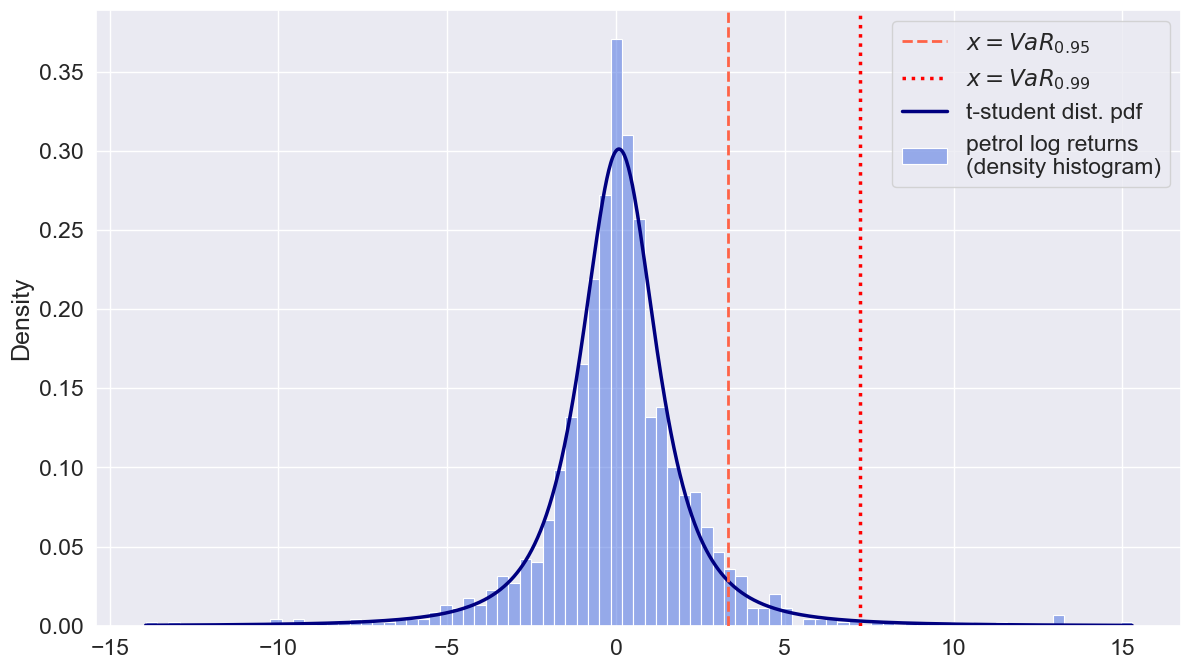

In [14]:
var_plot(L, t_student, VaR95_t, VaR99_t, show_pdf=True, label="t-student dist. pdf")

<h3 style="text-align:center;font-family:Didot;">Estimating VaR using parametric method &mdash; normal distribution</h3>

___

In [15]:
def normal_rv(data):
    return norm(*(norm.fit(data)))

In [16]:
norm_rv = normal_rv(L)
VaR95_norm, VaR99_norm = norm_rv.ppf([0.95, 0.99])
VaR95_norm, VaR99_norm

(3.874194503155802, 5.434107436769119)

In [17]:
kstest(L, norm_rv.cdf)

KstestResult(statistic=0.10195964023814152, pvalue=1.584520791702062e-12, statistic_location=0.826046337764613, statistic_sign=1)

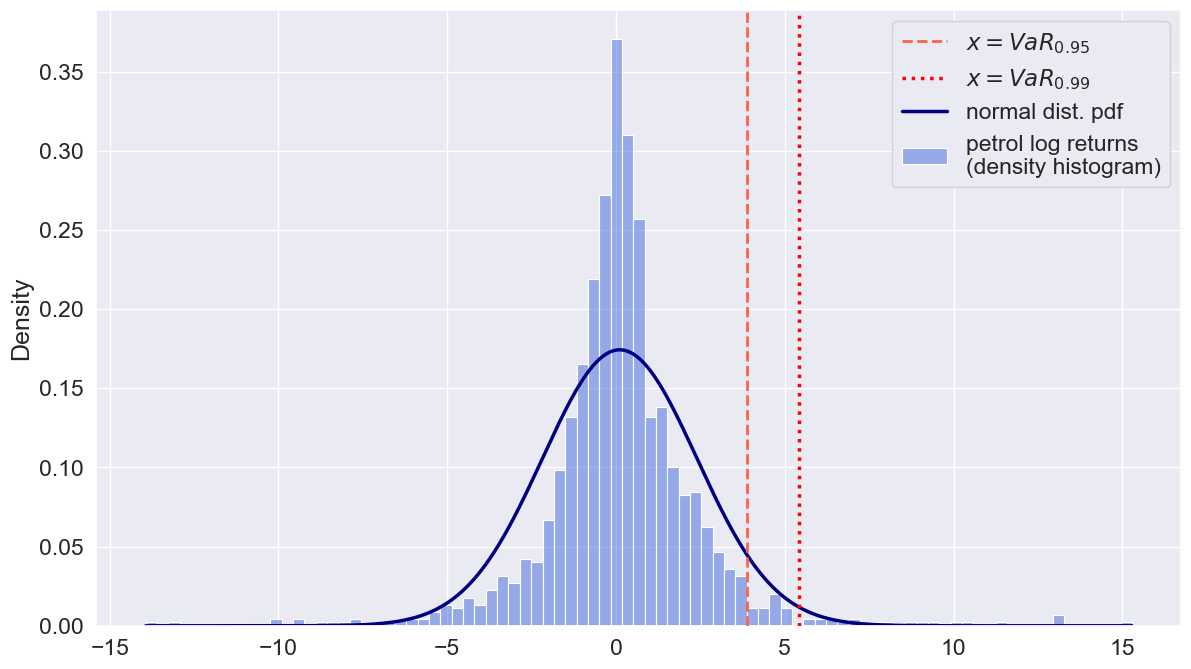

In [18]:
var_plot(L, norm_rv, VaR95_norm, VaR99_norm, show_pdf=True, label="normal dist. pdf")

<h3 style="text-align:center;font-family:Didot;">VaR using historical data</h3>

___

In [19]:
VaR95_hist = np.quantile(L, 0.95)
VaR99_hist = np.quantile(L, 0.99)
VaR95_hist, VaR99_hist

(3.3313425288714043, 6.833241184646061)

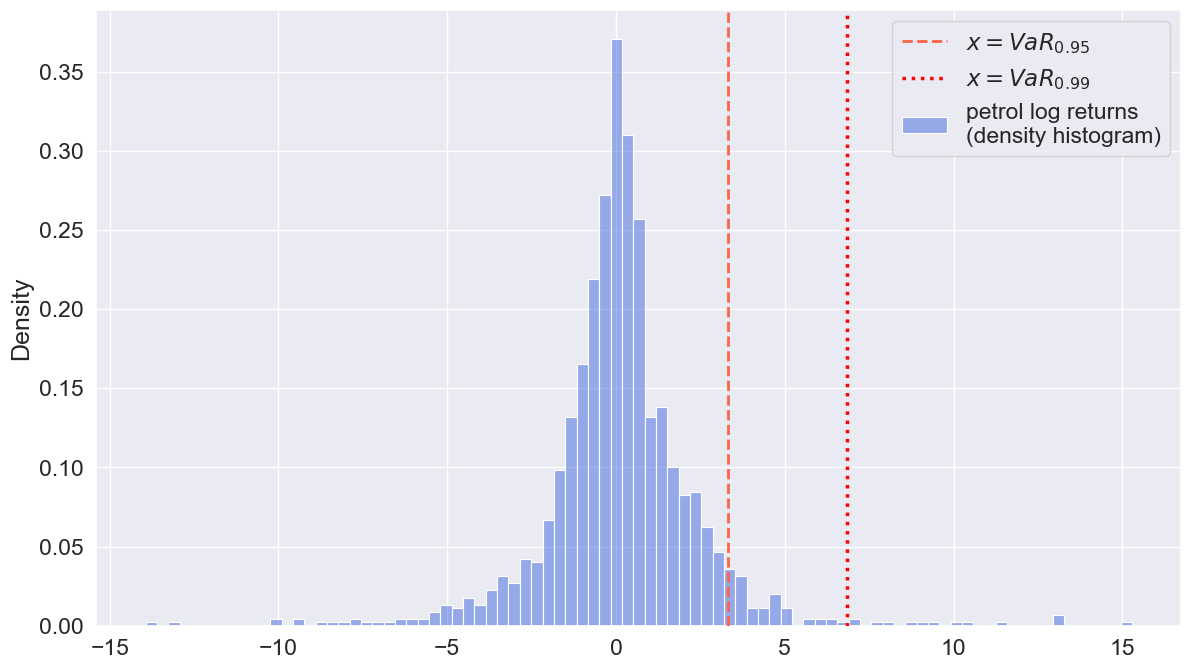

In [20]:
var_plot(L, None, VaR95_hist, VaR99_hist)

<h3 style="text-align:center;font-family:Didot;">VaR using historical data (weighted)</h3>

___

In [21]:
def weighted_quantile(L, alpha, lam=0.95):
    t = len(L)
    lambdas = np.repeat(lam, t-1)
    w1 = 1 / (1 + np.sum(np.cumprod(lambdas)))
    weights = w1*np.cumprod(lambdas)
    weights = np.insert(weights, 0, w1)
    
    Ls_ws = np.column_stack((np.flip(L), weights))  
    Ls_ws = Ls_ws[Ls_ws[:, 0].argsort()]            
    Ls_ws[:, 1] = np.cumsum(Ls_ws[:, 1])            
    k = np.argmax(Ls_ws[:, 1] >= alpha)
    VaR = Ls_ws[:, 0][k]
    return VaR

In [22]:
VaR95_weighted = weighted_quantile(L, 0.95, lam=0.999)
VaR99_weighted = weighted_quantile(L, 0.99, lam=0.999)
VaR95_weighted, VaR99_weighted

(3.5895218327796536, 9.01835029428439)

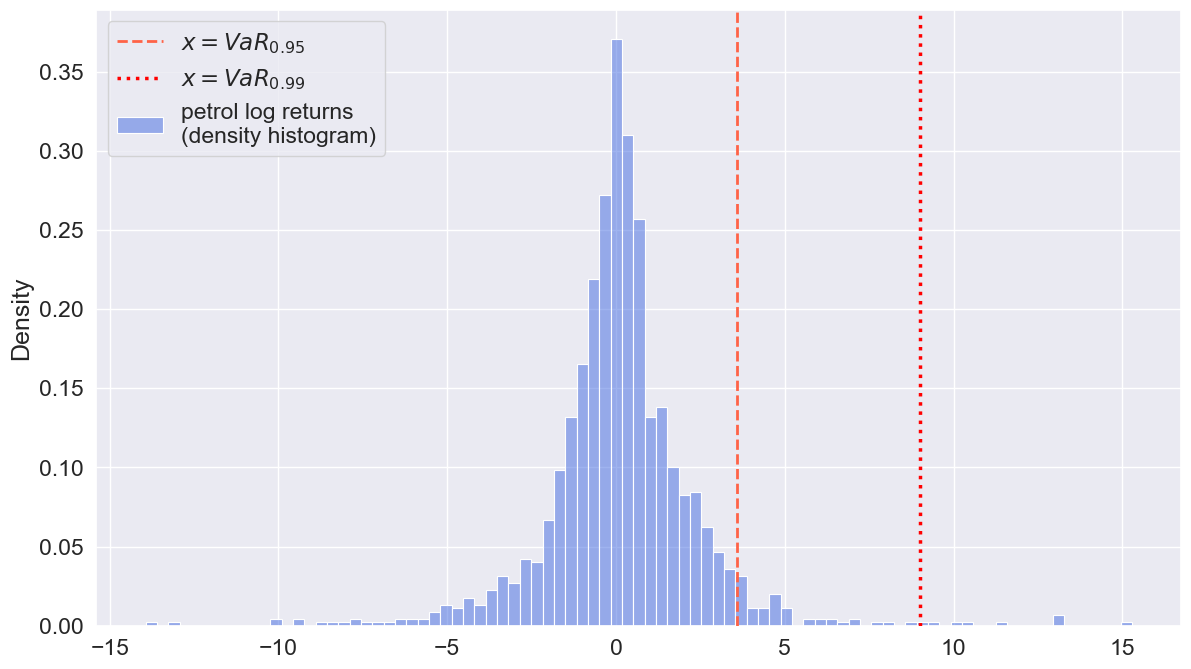

In [23]:
var_plot(L, None, VaR95_weighted, VaR99_weighted)

<h3 style="text-align:center;font-family:Didot;">VaR estimating with Garch model</h3>

___

In [24]:
def garch_filtered(data, alphas, p=1, q=1):
    model = arch_model(data, p=p, q=q, dist="skewt").fit(disp="off")
    forecast = model.forecast(reindex=False)
    std_t = np.sqrt(forecast.variance).iat[0, 0]
    mu = model.params["mu"]
    filtered = (data - mu) / model.conditional_volatility
    q = np.quantile(filtered, alphas)
    return mu + std_t * q

In [26]:
# AIC based parameters search
def find_garch_params(data, p_end, q_end, p_start=1, q_start=1, dist="skewt"):
    ps = range(p_start, p_end+1)
    qs = range(p_start, q_end+1)
    param_grid = list(product(ps, qs))
    best_idx = -1
    best_AIC = float('inf')
    for (idx, (p, q)) in enumerate(param_grid):
        model = arch_model(data, p=p, q=q, dist=dist).fit(disp="off")
        aic = model.aic
        if aic < best_AIC:
            best_AIC, best_idx = aic, idx
    return param_grid[best_idx]

In [27]:
# p, q = find_garch_params(L, 10, 10)
p, q = (1, 4)

Typical approach &mdash; GARCH $(1, 1)$

In [28]:
model = arch_model(L, p=1, q=1, dist="skewt").fit(disp="off")

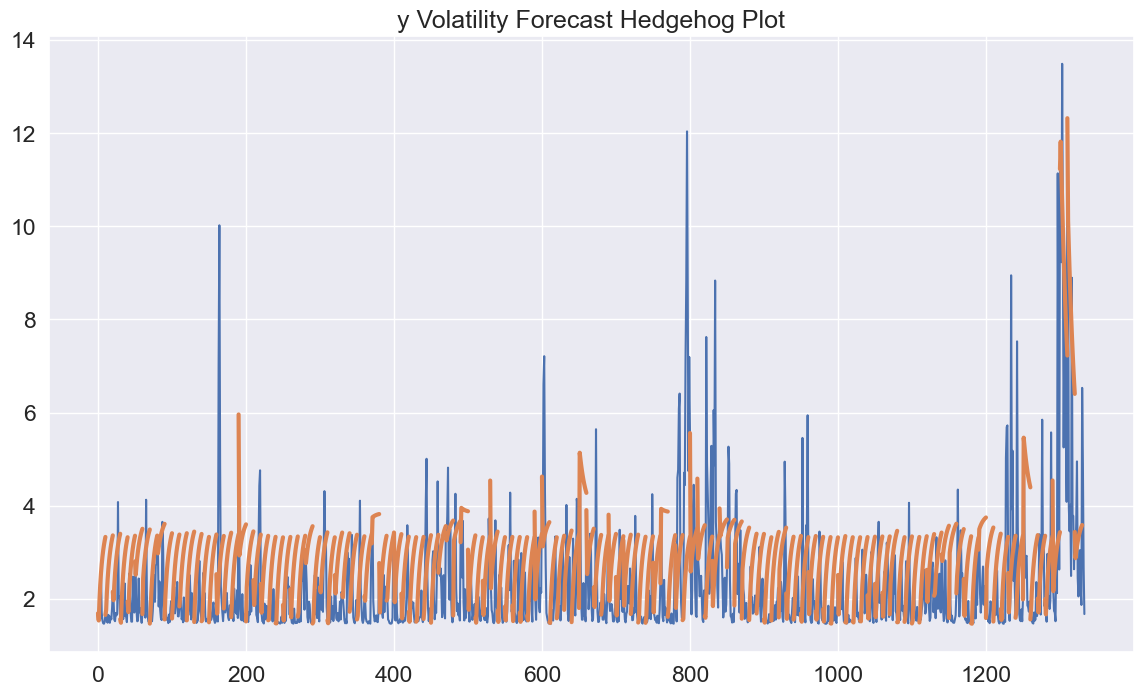

In [29]:
model.hedgehog_plot()
plt.show()

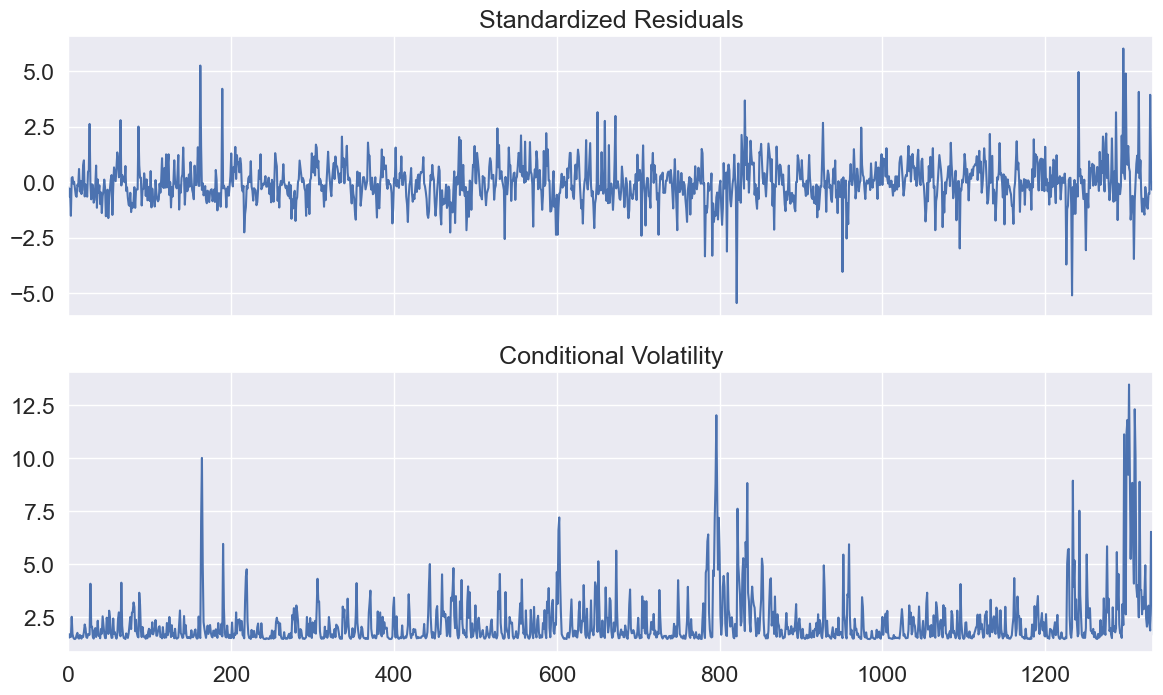

In [30]:
model.plot()
plt.show()

In [31]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Constant Mean - GARCH Model Results                           
=========================================================================================
Dep. Variable:                                 y   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                 GARCH   Log-Likelihood:               -2661.43
Distribution:      Standardized Skew Student's t   AIC:                           5334.86
Method:                       Maximum Likelihood   BIC:                           5366.03
                                                   No. Observations:                 1334
Date:                           Sat, Dec 16 2023   Df Residuals:                     1333
Time:                                   15:06:28   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1944  8.196e-02      2.371  1.772e-02 [3.373e-02,  0.355]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          1.8598      0.349      5.327  9.989e-08    [  1.176,  2.544]
alpha[1]       0.7396      0.137      5.392  6.970e-08    [  0.471,  1.008]
beta[1]        0.1350  8.680e-02      1.555      0.120 [-3.517e-02,  0.305]
                                Distribution                               
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
eta            3.4234      0.373      9.173  4.606e-20    [  2.692,  4.155]
lambda         0.0844  4.705e-02      1.794  7.275e-02 [-7.789e-03,  0.177]
===========================================================================

Covariance estimator: robust
"""

In [32]:
VaR95_garch, VaR99_garch = garch_filtered(L, [0.95, 0.99])
VaR95_garch, VaR99_garch

(2.4157838330804378, 4.204429963149658)

In [33]:
VaR95_garch, VaR99_garch = garch_filtered(L, [0.95, 0.99], p=1, q=4)
VaR95_garch, VaR99_garch

(4.9418451342337715, 8.75483969882734)

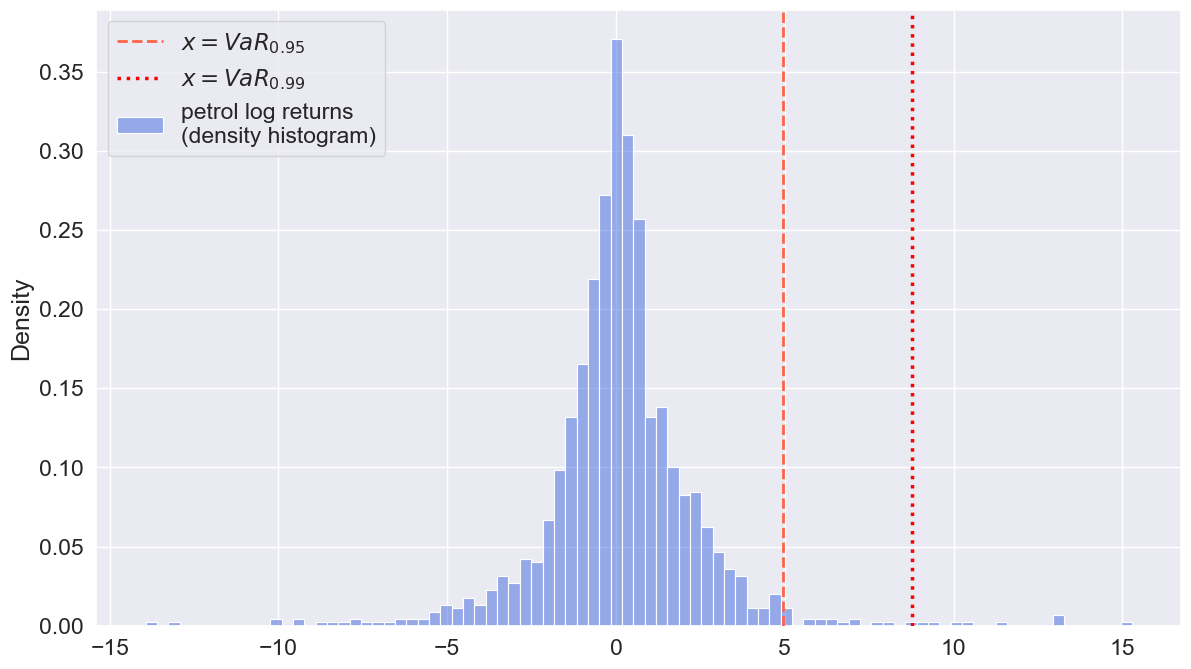

In [34]:
var_plot(L, None, VaR95_garch, VaR99_garch)

<h3 style="text-align:center;font-family:Didot;">Monte Carlo method</h3>

In [35]:
def logret(X, dt=1/365): 
    return np.diff(np.log(X)) / dt

In [107]:
X = pd.read_csv(os.path.join('data', 'fit', 'petrol_fit.csv')).price.to_numpy() / 1000

In [51]:
def euler_maruyama(process, X_0, *args, T=1/365, N=1):
    X = [X_0]
    dt = T / N
    dW = np.random.randn(N) * np.sqrt(dt)
    a, b = process(*args)
    for time_moment in range(N):
        X.append(X[-1] + a(X[-1], time_moment) * dt + b(X[-1], time_moment) * dW[time_moment])
    return np.array(X)

In [52]:
def log_euler_maruyama(process, X_0, *args, T=1/365, N=1):
    return logret(
        euler_maruyama(process, X_0, *args, T=T, N=N)
    )

In [53]:
def mc_var(process, X_0, *args, T=1/365, N=1, M=int(1e4), alpha=.95):
    return np.quantile(
        np.vectorize(lambda _: log_euler_maruyama(process, X_0, *args, T=T, N=N)[-1])(np.zeros(M)),
        alpha
    )

In [54]:
def gbm(mu, sigma):
    return lambda x, t: mu * x, lambda x, t: sigma * x

In [55]:
def gbm_est(X, T=1):
    L = np.log(X)
    volatility = np.var(np.diff(L)) * (len(L) - 1) / T
    drift = (L[-1] - L[0]) / T + volatility / 2
    return drift, np.sqrt(volatility)

In [56]:
VaR95_gbm = mc_var(gbm, X[-1], *gbm_est(X))
VaR99_gbm = mc_var(gbm, X[-1], *gbm_est(X), alpha=.99)

In [57]:
VaR95_gbm, VaR99_gbm

(8.53526177844674, 11.894893340032478)

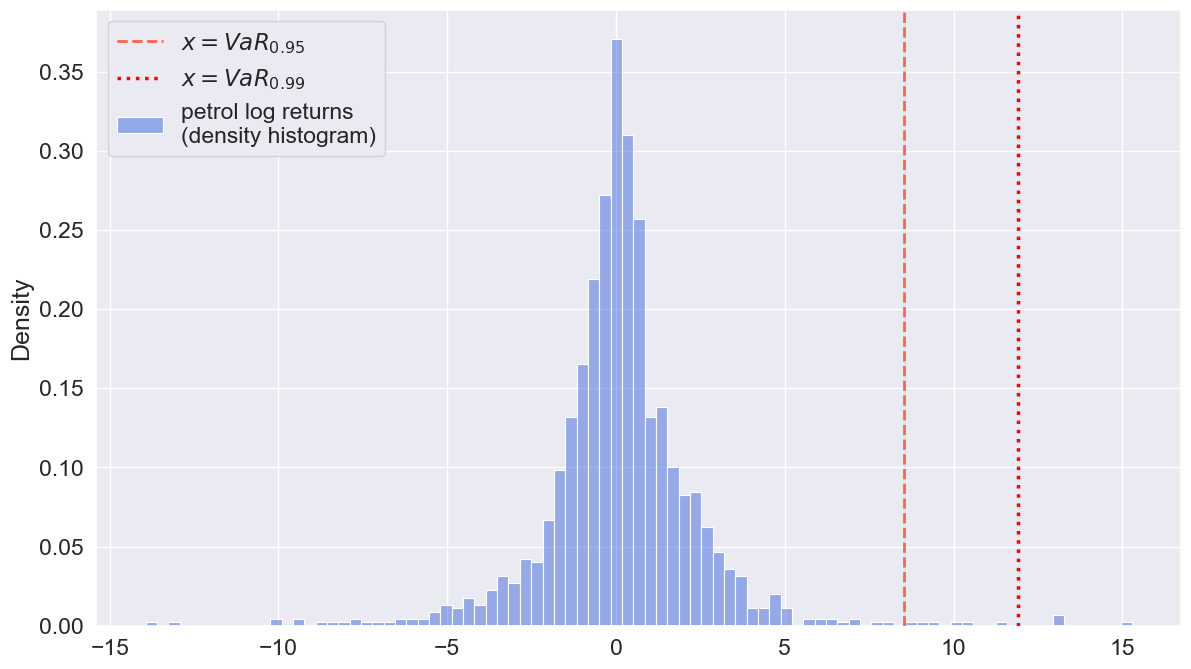

In [58]:
var_plot(L, None, VaR95_gbm, VaR99_gbm)

In [68]:
gsci = pd.read_excel(os.path.join('data', 'full', 'GSCI.xls'), skiprows=6).iloc[:-1, :]
gsci['S&P GSCI Petroleum'] = gsci['S&P GSCI Petroleum'].shift(1)
gsci.at[0, 'S&P GSCI Petroleum'] = gsci.at[1, 'S&P GSCI Petroleum']
gsci.dropna(inplace=True)
gsci['Effective date '] = pd.to_datetime(gsci['Effective date '])
gsci.rename({'S&P GSCI Petroleum': 'price', 'Effective date ': 'date'}, inplace=True, axis=1)

In [69]:
df = gsci
df = df[(df.date >= '2017') & ~(df.price.isna())]
df = df.sort_values('date')
Y = df.price.to_numpy() / 1000
V = (Y - np.mean(Y)) ** 2

In [70]:
def cir(a, b, sd):
    return lambda x, y, t: a * (b - x), lambda x, y, t: sd * np.sqrt(abs(x))

In [71]:
def cir_est(X, dt=1/365):
    reg = LinearRegression()
    x1 = dt / np.sqrt(np.abs(X[:-1]))
    x2 = -dt * np.sqrt(np.abs(X[:-1]))
    y = np.diff(X) / np.sqrt(np.abs(X[:-1]))
    reg.fit(np.stack((x1, x2)).T, y)
    reg.intercept_ = 0
    sd = np.sqrt(np.mean((reg.predict(np.stack((x1, x2)).T) - y)) ** 2) / dt
    a = reg.coef_[1]
    b = reg.coef_[0] / a
    return a, b, sd

In [72]:
def euler_maruyama_two(process1, process2, X_0, Y_0, corr, args1, args2, T=1/365, N=1):
    X = [X_0]
    Y = [Y_0]
    dt = T / N
    dW = np.random.multivariate_normal([0, 0], [[1, corr], [corr, 1]], size=N) * np.sqrt(dt)
    a1, b1 = process1(*args1)
    a2, b2 = process2(*args2)
    for time_moment in range(N):
        X.append(X[-1] + a1(X[-1], Y[-1], time_moment) * dt + b1(X[-1], Y[-1], time_moment) * dW[time_moment, 0])
        Y.append(Y[-1] + a2(Y[-1], X[-1], time_moment) * dt + b2(Y[-1], X[-1], time_moment) * dW[time_moment, 1])
    return np.array(X), np.array(Y)

In [73]:
def heston(mu):
    return lambda x, y, t: mu * x, lambda x, y, t: np.sqrt(np.abs(y)) * x

In [74]:
def heston_est(X, dt=1/365):
    return (np.mean(np.diff(X) / X[1:]) / dt,)

In [75]:
def mc_var_two(process1, process2, X_0, Y_0, corr, args1, args2, T=1/365, N=1, M=int(1e4), alpha=.95):
    return np.quantile(
                np.vectorize(lambda _: logret(euler_maruyama_two(process1, process2, X_0, Y_0, corr,
                                                                args1, args2, T=T, N=N)[1])[-1])(np.zeros(M)),
                alpha
            )

In [76]:
corr = np.corrcoef(X, V[:len(X)])[0, 1]
VaR95_heston = mc_var_two(cir, heston, V[-1], X[-1], corr, cir_est(V), heston_est(X))
VaR99_heston = mc_var_two(cir, heston, V[-1], X[-1], corr, cir_est(V), heston_est(X), alpha=.99)

In [77]:
VaR95_heston, VaR99_heston

(6.383562443069091, 9.558667154888036)

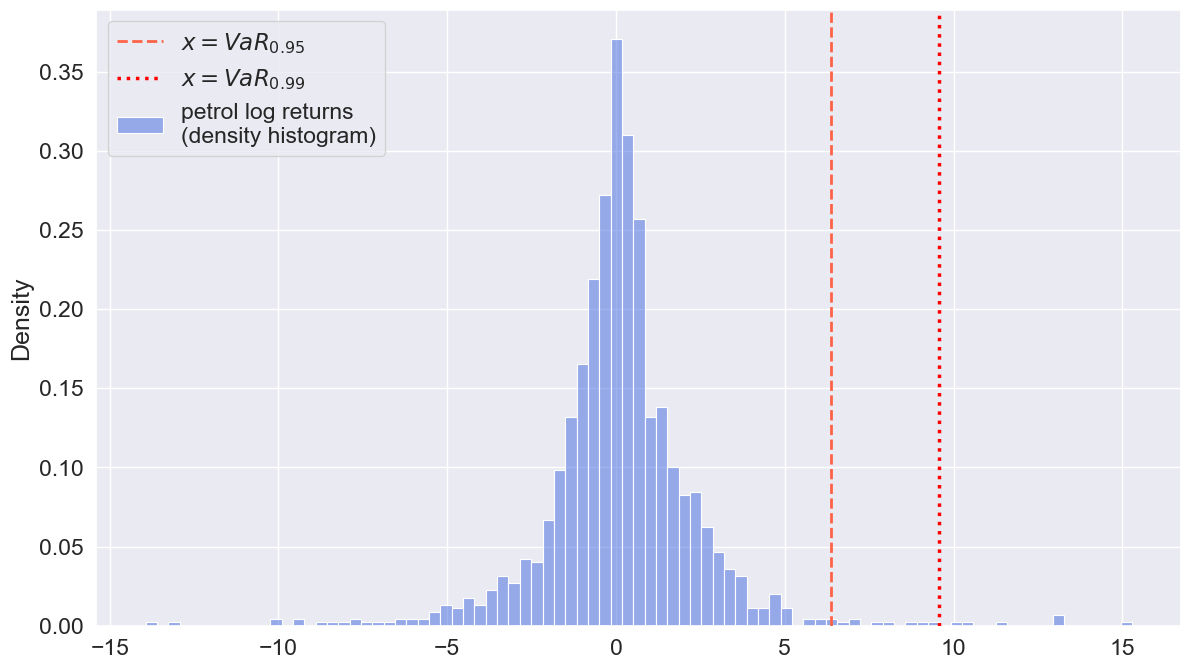

In [78]:
var_plot(L, None, VaR95_heston, VaR99_heston)

In [79]:
def find_arma_params(data, p_end, q_end, p_start=1, q_start=1):
    ps = range(p_start, p_end+1)
    qs = range(p_start, q_end+1)
    param_grid = list(product(ps, qs))
    best_idx = -1
    best_AIC = float('inf')
    for (idx, (p, q)) in enumerate(param_grid):
        model = ARIMA(data, order=(p, 0, q)).fit()
        aic = model.aic
        if aic < best_AIC:
            best_AIC, best_idx = aic, idx
    return param_grid[best_idx]

In [80]:
arma_params = find_arma_params(L, 5, 5)
arma_params

c:\Users\Manik\miniconda3\envs\financial\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Manik\miniconda3\envs\financial\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Manik\miniconda3\envs\financial\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Manik\miniconda3\envs\financial\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c

(4, 5)

In [81]:
def arma_var(X, p, q, steps=int(1e4), alpha=.95, N=1):
    model = ARIMA(X, order = (p, 0, q)).fit()
    return np.quantile(ARIMA(X, order=(p, 0, q)).simulate(model.params, N, repetitions=steps)[-1, :],
                       alpha)

c:\Users\Manik\miniconda3\envs\financial\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Manik\miniconda3\envs\financial\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


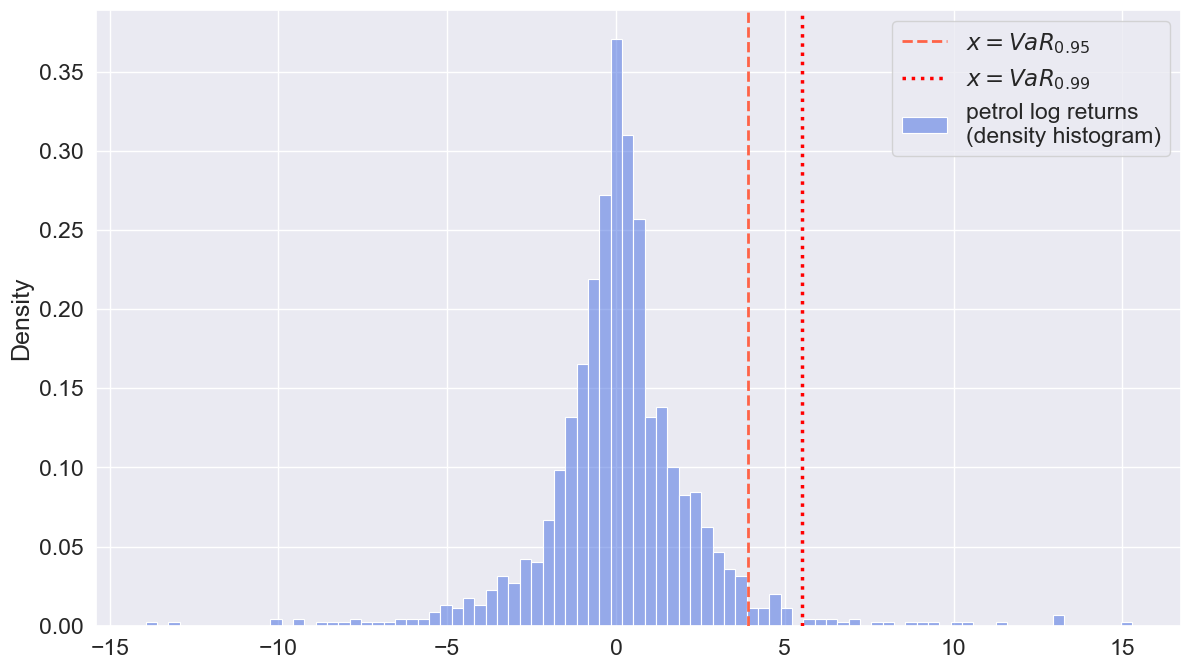

In [82]:
VaR95_arma = arma_var(L, *arma_params)
VaR99_arma = arma_var(L, *arma_params, alpha=.99)
var_plot(L, None, VaR95_arma, VaR99_arma)

<h2 style="text-align:center;font-family:Didot;">Part II</h2>

In [84]:
def parametric(data, alpha, dist):
    params = dist.fit(data)
    rv = dist(*params)
    return rv.ppf(alpha)

def historic(data, alpha):
    return np.quantile(data, alpha)

def mc(data, alpha, mc_method, *params):
    return mc_method(*params, alpha=alpha) 

def arma(data, alpha, *params):
    return arma_var(data, *params, alpha=alpha)

In [94]:
def backtesting_VaR(alpha, data, method, *method_params, window_length=600):
    n = len(data) - window_length - 1
    results = np.zeros(n)
    for i in range(n):
        VaR = method(data, alpha, *method_params)
        results[i] = data[window_length+i+1] < VaR
    return results


def save_results(filename, used_data, method, *method_params, alphas=[0.95, 0.99], window_length=600):
    array = np.zeros((len(used_data) - window_length - 1, 2))
    for idx, alpha in enumerate(alphas):
        result = backtesting_VaR(alpha, used_data, method, *method_params, window_length=window_length)
        array[:, idx] = result
    np.savetxt(os.path.join('data', "backtesting_results", f"{filename}.txt"), array)

In [99]:
# Takes some time
# save_results("historic", L, historic)
# save_results("t_student", L, parametric, t)
# save_results("weighted_historic", L, weighted_quantile, 0.999)
# save_results("garch", L, garch_filtered)
# save_results("garch_nonfinancial", L, garch_filtered, 1, 4)
# save_results('Heston', L, mc, mc_var_two, cir, heston, V[-1], X[-1], corr, cir_est(V), heston_est(X))

In [100]:
test_result = namedtuple("Result", "statistic p_value")


def independence_test(failures_vector):
    n = len(failures_vector)
    neighbours_counter = np.full([n, 4], 0)
    for i in range(1, n-1):
        neighbours_counter[i, 0] = (failures_vector[i-1] == 0) and (failures_vector[i] == 0)
        neighbours_counter[i, 1] = (failures_vector[i-1] == 0) and (failures_vector[i] == 1)
        neighbours_counter[i, 2] = (failures_vector[i-1] == 1) and (failures_vector[i] == 0)
        neighbours_counter[i, 3] = (failures_vector[i-1] == 1) and (failures_vector[i] == 1)
    I_00 = np.sum(neighbours_counter[:, 0])
    I_01 = np.sum(neighbours_counter[:, 1])
    I_10 = np.sum(neighbours_counter[:, 2])
    I_11 = np.sum(neighbours_counter[:, 3])
    p_00= I_00 / (I_00 + I_01)
    p_01= I_01 / (I_00 + I_01)
    p_10= I_10 / (I_10 + I_11)
    p_11= I_11 / (I_10 + I_11)
    hat_p = (I_01 + I_11) / (I_00 + I_01 + I_10 + I_11)
    al = np.log(1 - hat_p) * (I_00 + I_10) + np.log(hat_p) * (I_01 + I_11)
    bl = np.log(p_00) * I_00 + np.log(p_01) * I_01 + np.log(p_10) * I_10 + np.log(p_11) * I_11
    statistic = -2 * (al - bl)
    pvalue = 1 - chi2(df=1).cdf(statistic)
    return test_result(statistic, pvalue)


def kupiec_test(failures_vector, alpha):
    n = len(failures_vector)
    I1 = np.sum(failures_vector)
    I0 = n - I1
    p_hat = I1 / n
    statistic = -2 * (I0 * (np.log((1 - alpha) / (1 - p_hat))) + I1 * np.log(alpha / p_hat))
    p_value = 1 - chi2(df=1).cdf(statistic)
    return test_result(statistic, p_value)

In [106]:
# results printing
def markdown_table_printer(dictionary):
    s = pd.DataFrame(dictionary, index=[0]).to_markdown()
    return '\n'.join(map(lambda x: x[5:], s.split("\n"))) 


def backtesting_VaR_verification(name):
    array = np.loadtxt(os.path.join("data", "backtesting_results", f"{name}.txt"))
    for (idx, alpha) in enumerate([0.95, 0.99]):
        backtesting_result = array[:, idx]
        print(f"alpha = {alpha}")
        mean_, var_ = np.mean(backtesting_result), np.var(backtesting_result, ddof=1)
        result_dict =  {"Mean from backtesting": mean_, "Theoretical mean": alpha,
            "Variance from backtesing": var_, "Theoretical variance": alpha * (1 - alpha)}  
        print(markdown_table_printer(result_dict))
        kupiec_test_ = kupiec_test(backtesting_result, alpha)
        ind_test_ = independence_test(backtesting_result)
        print(f"\nKupiec test results: \n statistic: {kupiec_test_.statistic}, pvalue: {kupiec_test_.p_value}")
        print(f"\nIndependence test results: \n statistic: {ind_test_.statistic}, pvalue: {ind_test_.p_value}\n")

In [105]:
def nice_printer():
    print(120 * "-")

    
for name in ["t_student", "historic", "weighted_historic", "garch", "garch_nonfinancial", "Heston"]:
    print(f"### {name}")
    backtesting_VaR_verification(name)
    nice_printer()

### t_student
alpha = 0.95
|   Mean from backtesting |   Theoretical mean |   Variance from backtesing |   Theoretical variance |
|------------------------:|-------------------:|---------------------------:|-----------------------:|
|                0.930423 |               0.95 |                  0.0648245 |                 0.0475 |

Kupiec test results: 
 statistic: 5.299814317658402, pvalue: 0.021327697810789803

Independence test results: 
 statistic: 39.65612453760184, pvalue: 3.028535200400029e-10

alpha = 0.99
|   Mean from backtesting |   Theoretical mean |   Variance from backtesing |   Theoretical variance |
|------------------------:|-------------------:|---------------------------:|-----------------------:|
|                0.986357 |               0.99 |                  0.0134748 |                 0.0099 |

Kupiec test results: 
 statistic: 0.8820274995485882, pvalue: 0.3476469644045148

Independence test results: 
 statistic: 22.82242070748461, pvalue: 1.7768075247781567